In [1]:
import numpy as np
import pandas as pd
import pandas.tools.plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab
import matplotlib.gridspec
import japanize_matplotlib
import math
import seaborn as sns
import sys
import scipy
import IPython
import warnings
import collections
import random
import time
import optuna
import sklearn
import sklearn.preprocessing
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
import sklearn.discriminant_analysis 
import sklearn.preprocessing
import sklearn.manifold
import sklearn.linear_model
import sklearn.neighbors
import sklearn.utils
import sklearn.tree 
import sklearn.neural_network
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV,KFold
from sklearn.externals import joblib
import chainer
import chainer.training 
import xgboost
import lightgbm

import re

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [419]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [420]:
PassengerId = test['PassengerId']

In [421]:
full_data = [train, test]

# 乗客の名前の長さ
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 客室番号データがあるなら１を、欠損値なら0を
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 家族の大きさを"タイタニックに同乗している兄弟/配偶者の数"と
# "タイタニックに同乗している親/子供の数"から定義
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# 家族がいるかどうか
# いるなら"IsAlone"が１
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# 出港地の欠損値を一番多い"S"としておく
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# 料金の欠損値を中央値としておく
# 料金の大きく４つのグループに分ける
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# 年齢を５つのグループに分ける
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 名前を取り出す関数１
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # 名前があれば取り出して返す
    if title_search:
        return title_search.group(1)
    return ""

# 関数１を使う
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# 名前の変なところを変換
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # 女なら０、男なら１
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # 名前の5種類にラベル付
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # 出港地の3種類にラベル付
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # 料金を４つのグループに分ける
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # 年齢を5つのグループに分ける
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

# 必要ない特徴を削除
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


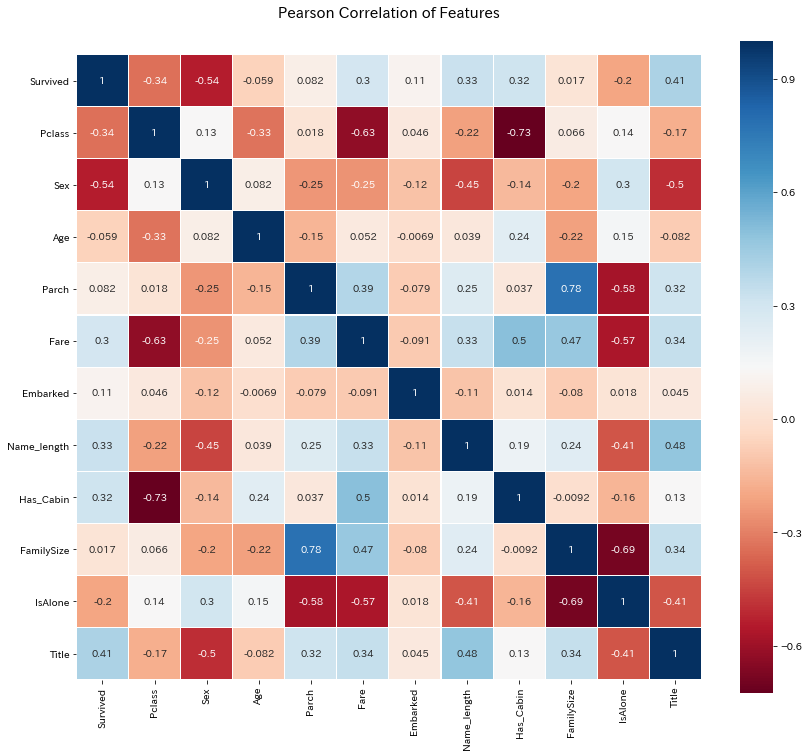

In [422]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# アンサンブル

In [484]:
# パラメータ
ntrain = train.shape[0] # 891
ntest = test.shape[0] # 418
SEED = 13
NFOLDS = 2 # 5分割
kf = KFold(n_splits= NFOLDS, random_state=SEED)
skf = StratifiedKFold(n_splits=NFOLDS,random_state=SEED)


# Sclearn分類機を拡張
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train,x_test,y_test):
        self.clf.fit(x_train, y_train,eval_set=[x_test,y_test],eval_metric="auc",early_stopping_rounds=10)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self,x,y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
    def predict_proba(self, x):
        return self.clf.predict_proba(x)

In [485]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [492]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_kf = np.empty((NFOLDS, ntest))
    train_auc = np.zeros(2)
    test_auc = np.zeros(2)
    
    #X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=13)
    #for i, (train_index, test_index) in enumerate(kf.split(x_train)): # NFOLDS回まわる
    for i, (train_index, test_index) in enumerate(skf.split(x_train,y_train)): # NFOLDS回まわる
        
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        y_te = y_train[test_index]

        clf.train(x_tr, y_tr,x_te,y_te)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_kf[i, :] = clf.predict_proba(x_test) [:,1]
        
        y_hat=clf.predict_proba(x_te)[:,1]
        test_auc[i]=roc_auc_score(y_te, y_hat)
        y_hat2=clf.predict_proba(x_tr)[:,1]
        train_auc[i]=roc_auc_score(y_tr, y_hat2)
        
    print("train auc : {}    test auc : {}".format(train_auc.mean(),test_auc.mean()))
    oof_test[:] = oof_test_kf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [487]:
def get_oof(clf, x_train,y_train, x_test):
    #X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=13)
    #for i, (train_index, test_index) in enumerate(kf.split(x_train)): # NFOLDS回まわる
    #for i, (train_index, test_index) in enumerate(skf.split(x_train,y_train)): # NFOLDS回まわる
        
        #x_tr = x_train[train_index]
        #y_tr = y_train[train_index]
        #x_te = x_train[test_index]
        #y_te = y_train[test_index]

    clf.train(x_train, y_train)

    oof_train = clf.predict_proba(x_train)[:,1]
    oof_test = clf.predict_proba(x_test) [:,1]
        
    train_auc=roc_auc_score(y_train, oof_train)
        
    print("train auc : {}".format(train_auc))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [493]:
# 各モデルのパラメータ


# Gradient Boosting
gb_params = {
    'n_estimators': 100,
     #'max_features': 0.2,
    'max_depth': 2,
    'min_samples_leaf': 2,
    'verbose': 0
}

#
et_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}


xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 2,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200,
}

cb_params = {
    'iterations': 100,
    'learning_rate': 0.5,
    'depth': 2,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lgb_params = {
    'n_estimators':100,
    'learning_rate':0.1,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':3,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

lr_params = {
    "C":10,
    "solver":'lbfgs',
}

In [494]:
# 5つの学習モデルのオブジェクトを作成
gb = SklearnHelper(clf=GradientBoostingClassifier,seed=SEED,params=gb_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
xgb = SklearnHelper(clf=xgboost.XGBClassifier,seed=SEED,params=xgb_params)
cb = SklearnHelper(clf=CatBoostClassifier, seed=SEED, params=cb_params)
lgb = SklearnHelper(clf=lightgbm.LGBMClassifier, seed=SEED, params=lgb_params)
lr = SklearnHelper(clf=LogisticRegression,seed=SEED,params=lr_params)

In [495]:
# 入力データの作成
#y_train = train['Survived'].ravel()
#train = train.drop(['Survived'], axis=1)
x_train = train.values # 学習データ
x_test = test.values # テストデータ

In [496]:
#標準化したデータ作成
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg,

In [498]:
xgb_oof_train, xgb_oof_test = get_oof(xgb,x_train, y_train, x_test) # XGBoost Classifier

ValueError: y contains previously unseen labels: [2, 3, 51]

# 第0層

In [497]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost Classifier
print("Gradient Boost Training is complete")
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees Classifier
print("Extra Trees Training is complete")
xgb_oof_train, xgb_oof_test = get_oof(xgb,x_train, y_train, x_test) # XGBoost Classifier
print("XGBoost Training is complete")
#cb_oof_train, cb_oof_test = get_oof(cb, x_train, y_train, x_test) # Cat Boost Classifier
#print("Cat Boosting Training is complete")
lgb_oof_train, lgb_oof_test = get_oof(lgb, x_train, y_train, x_test) # Light Gradient Boost Classifier
print("LightGBM Training is complete")
lr_oof_train, lr_oof_test = get_oof(lr,x_train_std, y_train, x_test_std) # Logistic Regression
print("Logistic Regression Training is complete")
print("All Training is complete")


TypeError: fit() got an unexpected keyword argument 'eval_set'

# 第1層

In [454]:
base_predictions_train = pd.DataFrame( {'GradientBoost': gb_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'XGBoost': xgb_oof_train.ravel(),
      'LightGBM': lgb_oof_train.ravel(),
        'Logistic': lr_oof_train.ravel()
    })
print('base_predictions_train.shape : ', base_predictions_train.shape)
base_predictions_train.head(5)

base_predictions_train.shape :  (891, 5)


,GradientBoost,ExtraTrees,XGBoost,LightGBM,Logistic
0,0.156032,0.113872,0.148934,0.184660,0.108659
1,0.992056,0.998813,0.976201,0.992733,0.990164
2,0.812280,0.683210,0.760590,0.898032,0.599156
3,0.992056,0.995480,0.976201,0.992733,0.993645
4,0.109853,0.066601,0.113225,0.153857,0.119228


In [455]:
x_train = np.concatenate(( gb_oof_train, et_oof_train, xgb_oof_train, lgb_oof_train, lr_oof_train), axis=1)
x_test = np.concatenate(( gb_oof_test, et_oof_test, xgb_oof_test, lgb_oof_test, lr_oof_test), axis=1)
print('x_train.shape : ', x_train.shape)
print('x_test.shape : ', x_test.shape)

x_train.shape :  (891, 5)
x_test.shape :  (418, 5)


In [456]:
gbm_final = xgboost.XGBClassifier(
learning_rate = 0.02,
 n_estimators= 50,
 max_depth= 2,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [459]:
lr_final=LogisticRegression(**lr_params).fit(x_train, y_train)
predictions=lr_final.predict(x_test)

In [483]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [499]:
train.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,23,0,2,0,1
1,1,0,2,0,3,1,51,1,2,0,3
2,3,0,1,0,1,0,22,0,1,1,2
3,1,0,2,0,3,0,44,1,2,0,3
4,3,1,2,0,1,0,24,0,1,1,1


# カラム追加

In [504]:
y=train["IsAlone"]
x=train.drop("IsAlone", axis=1)

In [519]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.3, random_state=3)

In [520]:
clf=lightgbm.LGBMClassifier(**lgb_params).fit(x_train,y_train)

In [521]:
y_hat_train=clf.predict_proba(x_train)[:,1]
train_auc=roc_auc_score(y_train, y_hat_train)

y_hat_test=clf.predict_proba(x_test)[:,1]
test_auc=roc_auc_score(y_test, y_hat_test)
        
print("train auc : {}    test auc : {}".format(train_auc,test_auc))

train auc : 1.0    test auc : 1.0


In [522]:
clf.predict(x_test)

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0])

In [216]:
train["Age_count"]=train["Age"].value_counts()

In [278]:
df = {'city': ['tokyo', 'nagoya', 'osaka', 'tokyo', 'nagoya', 'osaka', 'tokyo', 'osaka', 'tokyo'],'target': [0, 1, 0, 1, 0, 1, 0, 1, 0]}
df = pd.DataFrame(df)
df['city'] = df['city'].astype('category')

In [294]:
df=pd.DataFrame(np.arange(1,13),columns=["month"])

In [295]:
df

,month
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [329]:
df["month_sin"]=df["month"].apply(lambda x : np.sin((x/12)*2*round(np.pi,2)))
df["month_cos"]=df["month"].apply(lambda x : np.cos((x/12)*2*round(np.pi,2)))

In [379]:
df = pd.DataFrame(data=[x**2 for x in range(11)],
              index=list('abcdefghijk'),columns=["age"])
df2 = pd.DataFrame(data=[x*2-1for x in range(11)],
              index=list('abcdefghijk'),columns=["point"],)
df=pd.concat([df,df2],axis=1)

In [380]:
df

,age,point
a,0,-1
b,1,1
c,4,3
d,9,5
e,16,7
f,25,9
g,36,11
h,49,13
i,64,15
j,81,17


In [393]:
df["age"]=df["age"].astype("str")

In [396]:
df

,age,point
a,0,-1
b,1,1
c,4,3
d,9,5
e,16,7
f,25,9
g,36,11
h,49,13
i,64,15
j,81,17


In [398]:
df["age"].str.match("^1").astype(int)

a    0
b    1
c    0
d    0
e    1
f    0
g    0
h    0
i    0
j    0
k    1
Name: age, dtype: int64

In [399]:
df["age_begin_1"]=df["age"].str.match("^1").astype(int)

In [400]:
df

,age,point,age_begin_1
a,0,-1,0
b,1,1,1
c,4,3,0
d,9,5,0
e,16,7,1
f,25,9,0
g,36,11,0
h,49,13,0
i,64,15,0
j,81,17,0


In [365]:
from sklearn.metrics import pairwise
pairwise.rbf_kernel(df["age"][0],df["point"][0])

ValueError: Expected 2D array, got scalar array instead:
array=0.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [205]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import tuple_dataset
from chainer import training
from chainer.training import extensions

In [206]:
class NN(Chain):
    def __init__(self, n_in, n_units, n_out):
        super(NN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_units)
            self.l2 = L.Linear(n_units, n_units)
            self.l3 = L.Linear(n_units, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [207]:
epoch = 30
batch_size = 100
frequency = -1
n_in = len(train)
n_units = 100
n_out = 2

In [209]:
model = L.Classifier(NN(n_in, n_units, n_out))
chainer.cuda.get_device_from_id(0)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_device)
trainer = training.Trainer(updater, (epoch, 'epoch'))

trainer.extend(extensions.Evaluator(test_iter, model,device=gpu_device))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()

RuntimeError: CUDA environment is not correctly set up
(see https://github.com/chainer/chainer#installation).No module named 'cupy'

In [115]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:308: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


[0.1867885  0.50925654 0.04076881 0.18121358 0.08197257]
[0.23309252 0.46848375 0.05600416 0.07576014 0.16665941]
[0.24  0.226 0.106 0.082 0.138]
[0.02537659 0.92436285 0.01015272 0.01777201 0.02233583]


In [111]:
        clf = lightgbm.LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )

NameError: name 'trn_x' is not defined

In [68]:
rf_features=[0.12377855, 0.20217956, 0.02979123, 0.02111938, 0.06805216, 0.02444284,
 0.10262937, 0.06552361, 0.07044296, 0.01276213, 0.27927822]
et_features=[0.1282314,  0.37325939, 0.0292706,  0.01592016, 0.05587634, 0.02908468,
 0.05010627, 0.08276314, 0.04440573, 0.02071569, 0.1703666 ]
ada_features=[0.03 , 0.012 ,0.02 , 0.06  ,0.036 ,0.01  ,0.69  ,0.012, 0.056 ,0.002 ,0.072]
gb_features=[0.08816389, 0.01169876, 0.05290507, 0.01352354 ,0.0542907 , 0.02099272,
 0.16979804, 0.03710468, 0.11304853, 0.00633775, 0.43213632]

In [69]:
cols = train.columns.values
# 特徴の重要度データフレームを作成
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.123779,0.128231,0.030,0.088164
1,Sex,0.202180,0.373259,0.012,0.011699
2,Age,0.029791,0.029271,0.020,0.052905
3,Parch,0.021119,0.015920,0.060,0.013524
4,Fare,0.068052,0.055876,0.036,0.054291
5,Embarked,0.024443,0.029085,0.010,0.020993
6,Name_length,0.102629,0.050106,0.690,0.169798
7,Has_Cabin,0.065524,0.082763,0.012,0.037105
8,FamilySize,0.070443,0.044406,0.056,0.113049
9,IsAlone,0.012762,0.020716,0.002,0.006338


In [70]:
# 特徴の重要度の平均を計算

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1：行
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.123779,0.128231,0.030,0.088164,0.092543
1,Sex,0.202180,0.373259,0.012,0.011699,0.149784
2,Age,0.029791,0.029271,0.020,0.052905,0.032992
3,Parch,0.021119,0.015920,0.060,0.013524,0.027641
4,Fare,0.068052,0.055876,0.036,0.054291,0.053555
5,Embarked,0.024443,0.029085,0.010,0.020993,0.021130
6,Name_length,0.102629,0.050106,0.690,0.169798,0.253133
7,Has_Cabin,0.065524,0.082763,0.012,0.037105,0.049348
8,FamilySize,0.070443,0.044406,0.056,0.113049,0.070974
9,IsAlone,0.012762,0.020716,0.002,0.006338,0.010454


In [48]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')


NameError: name 'go' is not defined

In [116]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
print('base_predictions_train.shape : ', base_predictions_train.shape)
base_predictions_train.head(5)

base_predictions_train.shape :  (891, 4)


,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.873646,0.873726,0.501341,0.874667
1,0.101426,0.102560,0.498656,0.100000
2,0.789024,0.808700,0.500796,1.000000
3,0.101426,0.102560,0.498656,0.100000
4,0.873646,0.873726,0.501341,0.874667


In [117]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)
print('x_train.shape : ', x_train.shape)
print('x_test.shape : ', x_test.shape)

x_train.shape :  (891, 5)
x_test.shape :  (418, 5)


In [118]:
gbm = xgboost.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)
#predictions_proba=gbm.predict_proba(x_test)

In [120]:
# CSVファイルの作成 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [57]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1
3,3,1,1,0,1,0,16,0,1,1,1
4,3,0,1,1,1,0,44,0,3,0,3


array([[0.88489616, 0.11510387],
       [0.02801317, 0.97198683],
       [0.88489616, 0.11510387],
       [0.88489616, 0.11510387],
       [0.02801317, 0.97198683],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.88489616, 0.11510387],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.88489616, 0.11510387],
       [0.8915802 , 0.10841981],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.11436069, 0.8856393 ],
       [0.8534105 , 0.14658953],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.11436069, 0.8856393 ],
       [0.88489616, 0.11510387],
       [0.8534105 , 0.14658953],
       [0.88489616, 0.11510387],
       [0.

In [119]:
dd

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [123]:
xgboost.train

<function xgboost.training.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)>

In [125]:
xgboost.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [204]:
df = pd.DataFrame({'A': [2, 1, 0, 100, 51],
                   'B': [1, 2, 3, 4, 5],
                   'C': ['a', 'b', 'b', 'b', 'a']})

In [134]:
df["A_log"]=df["A"].apply(lambda x: np.log10(x/1000+1))

In [205]:
df

,A,B,C
0,2,1,a
1,1,2,b
2,0,3,b
3,100,4,b
4,51,5,a


In [153]:
df["age_rank"]=(np.floor(df["A"]/5)*5).astype("category")

In [154]:
df=pd.get_dummies(df,columns=["age_rank"])

In [149]:
df["age_rank2"]=df["A"]>5

In [155]:
df

,A,B,C,age_rank2,age_rank_50.0,age_rank_100.0,age_rank_0.0,age_rank_50.0,age_rank_100.0
0,2,1,a,False,0,0,1,0,0
1,1,2,b,False,0,0,1,0,0
2,0,3,b,False,0,0,1,0,0
3,100,4,b,True,0,1,0,0,1
4,51,5,a,True,1,0,0,1,0


In [158]:
!jupyter nbconvert --to python untitled.ipynb

[NbConvertApp] Converting notebook untitled.ipynb to python
[NbConvertApp] Writing 12221 bytes to untitled.py


In [172]:
from sklearn.model_selection import StratifiedKFold
X = np.array([[1, 0], [3, 1], [1, 1], [3, 0],[4,1],[5,1],[1,1],[3,1],[6,1],[9,1]])
y = np.array([1, 1, 1, 1,1,1,1,0,0,0])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
print(skf)  
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [4 5 6 9] TEST: [0 1 2 3 7 8]
TRAIN: [0 1 2 3 7 8] TEST: [4 5 6 9]


In [199]:
df['B_cate'] = df["B"].apply(lambda x : 1 if x == 1 else(2 if x==2 or x==3 else  3))

In [200]:
df

,A,B,C,B_cate_2,B_cate_3,B_cate
0,2,1,a,0,0,1
1,1,2,b,1,0,2
2,0,3,b,0,1,2
3,100,4,b,0,1,3
4,51,5,a,0,1,3


In [186]:
df=pd.get_dummies(df,columns=["B_cate"],drop_first=True)

In [206]:
df["A"][0]=np.nan

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
df.apply(lambda x: (x.isnull().sum())/len(x))

A    0.2
B    0.0
C    0.0
dtype: float64

In [210]:
df

,A,B,C
0,NaN,1,a
1,1.0,2,b
2,0.0,3,b
3,100.0,4,b
4,51.0,5,a


In [279]:
df = pd.DataFrame({
    'Name':['A','B','C','D','E','F', 'g'],
    'Class':[1,2,1,2,1,2, 3],
    'Score':[100,95,90,85,80,75,90]})

df

,Name,Class,Score
0,A,1,100
1,B,2,95
2,C,1,90
3,D,2,85
4,E,1,80
5,F,2,75
6,g,3,90


In [308]:
df.groupby('Name')["Class"].value_counts().unstack()

Class,1,2,3
Name,,,
A,1.0,NaN,NaN
B,NaN,1.0,NaN
C,1.0,NaN,NaN
D,NaN,1.0,NaN
E,1.0,NaN,NaN
F,NaN,1.0,NaN
g,NaN,NaN,1.0


In [280]:
df["Class"]

0    1
1    2
2    1
3    2
4    1
5    2
6    3
Name: Class, dtype: int64

In [297]:
df.query("Class >1 and Score >= 80")

,Name,Class,Score,new
1,B,2,95,B
3,D,2,85,D
6,g,3,90,g


In [299]:
df.filter("N")

""
0
1
2
3
4
5
6


In [298]:
df.iloc[df.query("Class >1 and Score >= 80").index]

,Name,Class,Score,new
1,B,2,95,B
3,D,2,85,D
6,g,3,90,g


In [290]:
df

,Name,Class,Score,new
0,A,1,100,NaN
1,B,2,95,B
2,C,1,90,NaN
3,D,2,85,D
4,E,1,80,NaN
5,F,2,75,NaN
6,g,3,90,g


In [246]:
df['cls_mean']=df.groupby('Class')['Score'].transform('mean')
df

,Name,Class,Score,cls_mean
0,A,1,100,90
1,B,2,95,85
2,C,1,90,90
3,D,2,85,85
4,E,1,80,90
5,F,2,75,85
6,g,3,90,90


In [242]:
ret = df.loc[df['cls_count'] >= 2, :]
ret

,Name,Class,Score,cls_count
0,A,1,100,3
1,B,2,95,3
2,C,1,90,3
3,D,2,85,3
4,E,1,80,3
5,F,2,75,3


In [258]:
df.loc[0,'Score'] = "A"

In [260]:
df

,Name,Class,Score,cls_mean
0,A,1,A,90
1,B,2,95,85
2,C,1,90,90
3,D,2,85,85
4,E,1,80,90
5,F,2,75,85
6,g,3,90,90


In [259]:
df["Score"].max()

TypeError: '>=' not supported between instances of 'str' and 'int'

In [265]:
import os
# some large memory data
create_large_df = lambda : pd.DataFrame(np.random.rand(100, 100), columns=[ "col_{}".format(n) for n in range(100)])

In [266]:
df = create_large_df()

In [267]:
import psutil

In [268]:
# expressed in bytes
psutil.virtual_memory()

svmem(total=8589934592, available=1671254016, percent=80.5, used=4523094016, free=100192256, active=1573003264, inactive=1567727616, wired=2950090752)

In [269]:
sys.getsizeof(df)

80104

In [270]:

global_obj_memory_usage = [(v, sys.getsizeof(eval(v))) for v in globals()] # 直接ループを回すと、途中でオブジェクト数が変わるのでエラーになる
for name, size in global_obj_memory_usage:
    print("{}: {} byte".format(name, size))

__name__: 57 byte
__doc__: 113 byte
__package__: 16 byte
__loader__: 16 byte
__spec__: 16 byte
__builtin__: 80 byte
__builtins__: 80 byte
_ih: 2536 byte
_oh: 2280 byte
_dh: 72 byte
In: 2536 byte
Out: 2280 byte
get_ipython: 64 byte
exit: 56 byte
quit: 56 byte
_: 28 byte
__: 112 byte
___: 960 byte
_i: 66 byte
_ii: 93 byte
_iii: 62 byte
_i1: 1104 byte
np: 80 byte
pd: 80 byte
pandas: 80 byte
matplotlib: 80 byte
plt: 80 byte
japanize_matplotlib: 80 byte
math: 80 byte
sns: 80 byte
sys: 80 byte
scipy: 80 byte
IPython: 80 byte
warnings: 80 byte
collections: 80 byte
random: 80 byte
time: 80 byte
optuna: 80 byte
sklearn: 80 byte
RandomForestRegressor: 1056 byte
SVC: 888 byte
OneVsRestClassifier: 1056 byte
train_test_split: 136 byte
confusion_matrix: 136 byte
accuracy_score: 136 byte
log_loss: 136 byte
cross_val_score: 136 byte
GridSearchCV: 1056 byte
KFold: 1056 byte
joblib: 80 byte
chainer: 80 byte
xgboost: 80 byte
lightgbm: 80 byte
_i2: 130 byte
_i3: 130 byte
_i4: 53 byte
_exit_code: 24 byte
_

In [271]:
# you can also use dir() instead of locals()
local_obj_memory_usage = [(v, sys.getsizeof(eval(v))) for v in locals()] # 直接ループを回すと、途中でオブジェクト数が変わるのでエラーになる。
for name, size in local_obj_memory_usage:
    print("{}: {} byte".format(name, size))

__name__: 57 byte
__doc__: 113 byte
__package__: 16 byte
__loader__: 16 byte
__spec__: 16 byte
__builtin__: 80 byte
__builtins__: 80 byte
_ih: 2536 byte
_oh: 2280 byte
_dh: 72 byte
In: 2536 byte
Out: 2280 byte
get_ipython: 64 byte
exit: 56 byte
quit: 56 byte
_: 28 byte
__: 112 byte
___: 960 byte
_i: 730 byte
_ii: 66 byte
_iii: 93 byte
_i1: 1104 byte
np: 80 byte
pd: 80 byte
pandas: 80 byte
matplotlib: 80 byte
plt: 80 byte
japanize_matplotlib: 80 byte
math: 80 byte
sns: 80 byte
sys: 80 byte
scipy: 80 byte
IPython: 80 byte
warnings: 80 byte
collections: 80 byte
random: 80 byte
time: 80 byte
optuna: 80 byte
sklearn: 80 byte
RandomForestRegressor: 1056 byte
SVC: 888 byte
OneVsRestClassifier: 1056 byte
train_test_split: 136 byte
confusion_matrix: 136 byte
accuracy_score: 136 byte
log_loss: 136 byte
cross_val_score: 136 byte
GridSearchCV: 1056 byte
KFold: 1056 byte
joblib: 80 byte
chainer: 80 byte
xgboost: 80 byte
lightgbm: 80 byte
_i2: 130 byte
_i3: 130 byte
_i4: 53 byte
_exit_code: 24 byte


In [36]:
train.drop("Survived")

KeyError: "['Survived'] not found in axis"

In [45]:
X_train,X_test,y_train,y_test = train_test_split(train.drop(columns="Survived").values,train["Survived"].values,test_size=0.2,random_state=0)

lgb_train = lightgbm.Dataset(np.array(X_train),np.array(y_train))
lgb_eval = lightgbm.Dataset(np.array(X_test),np.array(y_test),reference=lgb_train)
 

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2'},
    'num_leaves': 200,
    'learning_rate': 0.003,
    'num_iterations':1000,
    'feature_fraction': 0.52,
    'bagging_fraction': 0.79,
    'bagging_freq': 7,
    'verbose': 0
}

gbm = lightgbm.train(params,
                lgb_train,
                num_boost_round=500,
                early_stopping_rounds=100,
                valid_sets=lgb_eval)
X_pred= gbm.predict(np.array(test), num_iteration=gbm.best_iteration)

/Users/tomohiromunemasa/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.236248
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.235696
[3]	valid_0's l2: 0.235119
[4]	valid_0's l2: 0.234845
[5]	valid_0's l2: 0.234231
[6]	valid_0's l2: 0.233588
[7]	valid_0's l2: 0.233319
[8]	valid_0's l2: 0.233017
[9]	valid_0's l2: 0.232502
[10]	valid_0's l2: 0.232255
[11]	valid_0's l2: 0.231712
[12]	valid_0's l2: 0.231177
[13]	valid_0's l2: 0.230569
[14]	valid_0's l2: 0.230041
[15]	valid_0's l2: 0.229534
[16]	valid_0's l2: 0.228986
[17]	valid_0's l2: 0.228568
[18]	valid_0's l2: 0.227973
[19]	valid_0's l2: 0.227482
[20]	valid_0's l2: 0.227203
[21]	valid_0's l2: 0.226762
[22]	valid_0's l2: 0.226534
[23]	valid_0's l2: 0.22609
[24]	valid_0's l2: 0.225863
[25]	valid_0's l2: 0.225409
[26]	valid_0's l2: 0.225025
[27]	valid_0's l2: 0.224817
[28]	valid_0's l2: 0.224595
[29]	valid_0's l2: 0.224097
[30]	valid_0's l2: 0.223647
[31]	valid_0's l2: 0.223158
[32]	valid_0's l2: 0.222878
[33]	valid_0's l2: 0.222317
[34]	valid_0's l2: 0.22

[285]	valid_0's l2: 0.159414
[286]	valid_0's l2: 0.159248
[287]	valid_0's l2: 0.159151
[288]	valid_0's l2: 0.158946
[289]	valid_0's l2: 0.158846
[290]	valid_0's l2: 0.158767
[291]	valid_0's l2: 0.158691
[292]	valid_0's l2: 0.158589
[293]	valid_0's l2: 0.158415
[294]	valid_0's l2: 0.158268
[295]	valid_0's l2: 0.158102
[296]	valid_0's l2: 0.157921
[297]	valid_0's l2: 0.157809
[298]	valid_0's l2: 0.157631
[299]	valid_0's l2: 0.157481
[300]	valid_0's l2: 0.157399
[301]	valid_0's l2: 0.157351
[302]	valid_0's l2: 0.157135
[303]	valid_0's l2: 0.156908
[304]	valid_0's l2: 0.156845
[305]	valid_0's l2: 0.156663
[306]	valid_0's l2: 0.156501
[307]	valid_0's l2: 0.156352
[308]	valid_0's l2: 0.156277
[309]	valid_0's l2: 0.156174
[310]	valid_0's l2: 0.156089
[311]	valid_0's l2: 0.155917
[312]	valid_0's l2: 0.155842
[313]	valid_0's l2: 0.155709
[314]	valid_0's l2: 0.155602
[315]	valid_0's l2: 0.155479
[316]	valid_0's l2: 0.155375
[317]	valid_0's l2: 0.155188
[318]	valid_0's l2: 0.155041
[319]	valid_0'

[568]	valid_0's l2: 0.135974
[569]	valid_0's l2: 0.135925
[570]	valid_0's l2: 0.135852
[571]	valid_0's l2: 0.135826
[572]	valid_0's l2: 0.135803
[573]	valid_0's l2: 0.135771
[574]	valid_0's l2: 0.135752
[575]	valid_0's l2: 0.135721
[576]	valid_0's l2: 0.135694
[577]	valid_0's l2: 0.135636
[578]	valid_0's l2: 0.135606
[579]	valid_0's l2: 0.135545
[580]	valid_0's l2: 0.135516
[581]	valid_0's l2: 0.135446
[582]	valid_0's l2: 0.13538
[583]	valid_0's l2: 0.135339
[584]	valid_0's l2: 0.135333
[585]	valid_0's l2: 0.135305
[586]	valid_0's l2: 0.135291
[587]	valid_0's l2: 0.135235
[588]	valid_0's l2: 0.135202
[589]	valid_0's l2: 0.13518
[590]	valid_0's l2: 0.13514
[591]	valid_0's l2: 0.135111
[592]	valid_0's l2: 0.135084
[593]	valid_0's l2: 0.135057
[594]	valid_0's l2: 0.135007
[595]	valid_0's l2: 0.134965
[596]	valid_0's l2: 0.134931
[597]	valid_0's l2: 0.134901
[598]	valid_0's l2: 0.134866
[599]	valid_0's l2: 0.134803
[600]	valid_0's l2: 0.134788
[601]	valid_0's l2: 0.134747
[602]	valid_0's l

[851]	valid_0's l2: 0.129504
[852]	valid_0's l2: 0.129487
[853]	valid_0's l2: 0.129492
[854]	valid_0's l2: 0.129493
[855]	valid_0's l2: 0.129489
[856]	valid_0's l2: 0.129473
[857]	valid_0's l2: 0.129479
[858]	valid_0's l2: 0.129453
[859]	valid_0's l2: 0.129445
[860]	valid_0's l2: 0.129426
[861]	valid_0's l2: 0.129419
[862]	valid_0's l2: 0.129393
[863]	valid_0's l2: 0.129385
[864]	valid_0's l2: 0.129372
[865]	valid_0's l2: 0.12937
[866]	valid_0's l2: 0.12937
[867]	valid_0's l2: 0.129383
[868]	valid_0's l2: 0.129395
[869]	valid_0's l2: 0.12939
[870]	valid_0's l2: 0.129376
[871]	valid_0's l2: 0.12936
[872]	valid_0's l2: 0.129347
[873]	valid_0's l2: 0.129328
[874]	valid_0's l2: 0.129311
[875]	valid_0's l2: 0.129302
[876]	valid_0's l2: 0.129295
[877]	valid_0's l2: 0.129279
[878]	valid_0's l2: 0.129275
[879]	valid_0's l2: 0.129252
[880]	valid_0's l2: 0.129232
[881]	valid_0's l2: 0.12922
[882]	valid_0's l2: 0.129198
[883]	valid_0's l2: 0.129204
[884]	valid_0's l2: 0.129201
[885]	valid_0's l2:

In [55]:
importance = pd.DataFrame(gbm.feature_importance(), index=train.drop(columns="Survived").columns, columns=['importance'])
display(importance)

,importance
Pclass,1389
Sex,345
Age,1658
Parch,722
Fare,2197
Embarked,1118
Name_length,5022
Has_Cabin,618
FamilySize,1560
IsAlone,458


In [72]:
importance["rank"]=importance.rank(ascending=False)

In [73]:
importance

,importance,rank
Pclass,1389,5.0
Sex,345,11.0
Age,1658,3.0
Parch,722,8.0
Fare,2197,2.0
Embarked,1118,6.0
Name_length,5022,1.0
Has_Cabin,618,9.0
FamilySize,1560,4.0
IsAlone,458,10.0


In [75]:
importance_top5_index=importance.query("rank<=5").index

In [82]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

# 学習データとテストデータを分ける
X_train,X_test,y_train,y_test = train_test_split(train.drop(columns="Survived").values,train["Survived"].values,test_size=0.2,random_state=0)

# 学習条件を設定
model = lgb.LGBMClassifier(num_leaves = 23,
                        learning_rate=0.1,
                        n_estimators=100)

# 学習する
result = model.fit(X_train, y_train,
                   eval_set=[(X_test, y_test)],
                   eval_metric='multi_logloss',
                   early_stopping_rounds=20)

# テストデータで予測する
y_pred = model.predict(X_test, num_iteration=result.best_iteration_)

# Accuracy を計算する
accuracy = sum(y_test == y_pred) / len(y_test)
print()
print('accuracy:', accuracy)

[1]	valid_0's binary_logloss: 0.622631	valid_0's binary_logloss: 0.622631
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.588364	valid_0's binary_logloss: 0.588364
[3]	valid_0's binary_logloss: 0.562082	valid_0's binary_logloss: 0.562082
[4]	valid_0's binary_logloss: 0.5383	valid_0's binary_logloss: 0.5383
[5]	valid_0's binary_logloss: 0.518101	valid_0's binary_logloss: 0.518101
[6]	valid_0's binary_logloss: 0.50334	valid_0's binary_logloss: 0.50334
[7]	valid_0's binary_logloss: 0.489785	valid_0's binary_logloss: 0.489785
[8]	valid_0's binary_logloss: 0.47864	valid_0's binary_logloss: 0.47864
[9]	valid_0's binary_logloss: 0.47079	valid_0's binary_logloss: 0.47079
[10]	valid_0's binary_logloss: 0.46248	valid_0's binary_logloss: 0.46248
[11]	valid_0's binary_logloss: 0.457726	valid_0's binary_logloss: 0.457726
[12]	valid_0's binary_logloss: 0.45002	valid_0's binary_logloss: 0.45002
[13]	valid_0's binary_logloss: 0.446803	valid_0's binary_logl

In [84]:
# テストデータで予測する
y_pred = model.predict(X_train, num_iteration=result.best_iteration_)

# Accuracy を計算する
accuracy = sum(y_train == y_pred) / len(y_train)
print()
print('accuracy:', accuracy)


accuracy: 0.875


In [83]:
importance = pd.DataFrame(gbm.feature_importance(), index=train.drop(columns="Survived").columns, columns=['importance'])
display(importance)

,importance
Pclass,1389
Sex,345
Age,1658
Parch,722
Fare,2197
Embarked,1118
Name_length,5022
Has_Cabin,618
FamilySize,1560
IsAlone,458


In [87]:
importance["rank"]=importance.rank(ascending=False).astype("int")

In [88]:
importance

,importance,rank
Pclass,1389,5
Sex,345,11
Age,1658,3
Parch,722,8
Fare,2197,2
Embarked,1118,6
Name_length,5022,1
Has_Cabin,618,9
FamilySize,1560,4
IsAlone,458,10


In [97]:
X=train.drop(columns="Survived")

In [107]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(X)

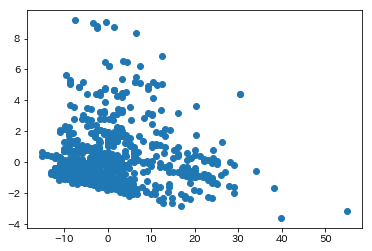

In [108]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

In [109]:
X_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X)


NameError: name 'LinearDiscriminantAnalysis' is not defined